# Frac Production Modeling Multiple States

This is a continuation of Frac Production Modeling for Colorado.  Here I will combine the data with other states and model the data.

In [1]:
# Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model Imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

Great, now I will write two functions to streamline training and testing the models.  The training function will fit the model and then cross validate the scores and return the scores.  The test function will cross validate and return the scores.

In [2]:
def train_model(model, X, Y, cv):
    """This function will fit the specified model and run cross validation on the training
    and set.  Returns mean and variance in cross validation scores.
    Model: specified model must be instantiated
    X, Y: training sets to use to fit model
    cv: number of folds in cross validation"""
    model.fit(X, Y)
    scores = cross_val_score(model, X, Y, cv=cv)
    return '{:0.4f} (+/- {:0.4f})'.format(scores.mean(), scores.std()*2)

def test_model(model, X, Y, cv):
    """This function will run cross validation on the test set.  
    Returns mean and variance in cross validation scores.
    Model: specified model must be instantiated
    X, Y: test sets to use to fit model
    cv: number of folds in cross validation"""
    scores = cross_val_score(model, X, Y, cv=cv)
    return '{:0.4f} (+/- {:0.4f})'.format(scores.mean(), scores.std()*2)


### Colorado Data

In [3]:
# Reading in only engineered Colorado Features
cofeatures = pd.read_csv('cofeatures.csv', index_col=0, usecols=['APINumber','VerticalDepth','First6BOE', 'nphf_sqrt', 
                                                            'slick','gel','xlinkgel','sandperft','hybrid',
                                                            'hzlen_bin_1-2','hzlen_bin_<1','hzlen_bin_>2'])
cofeatures.head()

,gel,slick,xlinkgel,hybrid,VerticalDepth,nphf_sqrt,sandperft,First6BOE,hzlen_bin_<1,hzlen_bin_1-2,hzlen_bin_>2
APINumber,,,,,,,,,,,
5001098010000,0,1,1,1.0,7774.00,73.120155,249.373188,46241.0,1,0,0
5001097850000,0,1,1,1.0,7576.73,73.515340,268.887993,7094.0,1,0,0
5001097830000,0,1,1,1.0,7511.68,73.525313,250.320443,8304.0,1,0,0
5001097820000,0,1,1,1.0,7574.72,73.519946,228.313165,7118.0,1,0,0
5001097810000,0,1,1,1.0,7513.70,73.516289,252.211029,10385.0,1,0,0


Knowing that this data is clean, I will first identify my variables, with the first 6 month's production as the target and the remainder as features in the model.  I will then split both variables into training and test sets.

In [4]:
# Identifying all engineered features
cofeats = cofeatures.drop(['First6BOE'], axis=1)
print(cofeats.shape)
cotarget = cofeatures.First6BOE

(4502, 10)


Great, now let's load in other state data.

### Oklahoma Data

In [5]:
# Reading in Oklahoma features
okfeatures = pd.read_csv('okfeatures', index_col=0).dropna()
# Dropping features not in Colorado data
okfeatures = okfeatures.drop(['sqrtsandmass'], axis=1)
print(okfeatures.shape)
okfeatures.head()

(10358, 11)


,gel,slick,xlinkgel,VerticalDepth,nphf_sqrt,First6BOE,SandMassPerFoot,hybrid,hzlen_bin_<1,hzlen_bin_1-2,hzlen_bin_>2
APINumber,,,,,,,,,,,
35051238300000,0,1,0,12246.0,79.170702,62733.0,637.0,0,1,0,0
42483338530000,0,1,0,13487.0,77.038951,132965.0,882.0,0,1,0,0
42375318560000,0,1,0,9335.0,79.328431,155981.0,1507.0,0,1,0,0
35043232790000,0,1,0,8968.0,78.025637,10426.0,722.0,0,1,0,0
35149215590000,0,1,0,12735.0,77.498387,51461.0,665.0,0,1,0,0


Since there are two prefix numbers for the API numbers, this means that there are actually two states in this data set.  State prefix 35 is for Oklahoma, and state prefix 42 is Texas.

In [6]:
# Renaming Sand mass per foot for consistency with Colorado's feature
okfeatures.columns = ['gel', 'slick', 'xlinkgel', 'VerticalDepth', 'nphf_sqrt', 'First6BOE',
       'sandperft', 'hybrid', 'hzlen_bin_<1', 'hzlen_bin_1-2',
       'hzlen_bin_>2']

In [7]:
# Splitting out Oklahoma wells
okwellfeatures = okfeatures[okfeatures.index <40000000000000]
print(okwellfeatures.shape)
# Splitting out Texas wells
txwellfeatures = okfeatures[okfeatures.index >40000000000000]
print(txwellfeatures.shape)

(7904, 11)
(2454, 11)


In [8]:
# Identifying variables for Oklahoma
oktarget = okwellfeatures.First6BOE
okfeats = okwellfeatures.drop('First6BOE', axis=1)
print(okfeats.shape)

# Identifying variables for Texas
txtarget = txwellfeatures.First6BOE
txfeats = txwellfeatures.drop('First6BOE', axis=1)
print(txfeats.shape)

(7904, 10)
(2454, 10)


### Montana Data

In [13]:
# Reading in Montana data
mtfeatures = pd.read_csv('mtfeatures.csv', index_col=0).dropna()
print(mtfeatures.shape)
mtfeatures.head()

(9642, 12)


,gel,slick,xlinkgel,hybrid,VerticalDepth,nphf_sqrt,sqrtsandmass,First6BOE,sandperft,hzlen_bin_<1,hzlen_bin_1-2,hzlen_bin_>2
APINumber,,,,,,,,,,,,
25085219780000,0,1,0,0.0,10071.91,119.565811,3540.964318,112335.67,1244.890820,0,0,1
25085219820000,0,1,0,0.0,10149.72,119.890755,3482.759695,103295.83,1195.068937,0,0,1
25085219830000,0,1,0,0.0,10185.45,120.039673,3211.662658,109993.67,1012.697233,0,0,1
33025020720000,0,1,1,1.0,10775.58,116.429349,1614.653077,36293.00,279.380924,0,0,1
33025020730000,0,1,1,1.0,10849.07,121.762282,1333.051429,27982.17,167.612664,0,0,1


In [14]:
# Identifying features for Montana
mttarget = mtfeatures.First6BOE
mtfeats = mtfeatures.drop(['First6BOE', 'sqrtsandmass'], axis=1)
print(mtfeats.shape)

(9642, 10)


Great! Now that we have all of our data and variables identified, I will concatenate them together.

### Concatenating Data

In [15]:
# Concatenating all features together
all_states = pd.concat([cofeats, okfeats, txfeats, mtfeats], axis=0)
print(all_states.shape)

# Concatenating all targets together
all_targets = pd.concat([cotarget, oktarget, txtarget, mttarget], axis=0)
print(all_targets.shape)
all_states.tail()

(24502, 10)
(24502,)


,VerticalDepth,gel,hybrid,hzlen_bin_1-2,hzlen_bin_<1,hzlen_bin_>2,nphf_sqrt,sandperft,slick,xlinkgel
APINumber,,,,,,,,,,
33025020670000,10994.51,0,1.0,0,0,1,124.016181,294.501646,1,1
33025020680000,11157.81,0,1.0,0,0,1,118.074058,343.637265,1,1
33025020690000,11103.75,0,1.0,0,0,1,117.983826,341.205032,1,1
33025020700000,10981.19,0,1.0,0,0,1,118.985181,178.683123,1,1
33025020710000,10969.89,0,1.0,0,0,1,119.010559,177.652378,1,1


Alright, now that I have all of the data together, I need to split that into training and test sets.  I will keep out a test size of 25%.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(all_states, all_targets, test_size=0.25, random_state=42)

## Modeling
### Random Forest Regressor
I will start with a simple random forest model to determine how well this data predicts production for all four states.

In [18]:
# Instantiate the model
rfr = RandomForestRegressor(random_state=42)

# Fit the model and generate training scores
rfr_train = train_model(rfr, X_train, y_train, 5)
# Generate test scores
rfr_test = test_model(rfr, X_test, y_test, 5)
print('Training Scores: {}'.format(rfr_train))
print('Test Scores: {}'.format(rfr_test))

Training Scores: 0.2846 (+/- 0.0471)
Test Scores: 0.2016 (+/- 0.0841)


The good thing about this result is that the variance in the test set was greatly reduced, likely because of the increase in number of samples, however the model was only able to explain the variance in 20% of the samples, with an R-squared of 0.20 +/- 0.08.

Let's try and optimize the parameters of this model, including the number of estimators, the maximum number of features to use, the minimum samples split, and the maximum depth of the tree.

In [20]:
# Identifying potential parameters
param_grid = { 
            "n_estimators"      : [200,400,600],
            "max_features"      : ["sqrt"],
            "min_samples_split" : [2,4,6,8],
            "max_depth": [4,6,8]
            }
# Instantiating grid search
grid = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5)
# Fitting model
grid.fit(X_train, y_train)
# Identifying best score and best parameters from the Grid Search
print(grid.best_score_)
best_params = grid.best_params_
print(best_params)

0.3316304169005333
{'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 400}


Using these optimal parameters, let's now apply those parameters to a new model.

In [21]:
# Instantiate the model
rfr_grid = RandomForestRegressor(**best_params, random_state=42)
# Fit the model and generate training scores
rfr_grid_train = train_model(rfr_grid, X_train, y_train, 5)
# Generate test scores
rfr_grid_test = test_model(rfr_grid, X_test, y_test, 5)

print('Training Scores: {}'.format(rfr_grid_train))
print('Test Scores: {}'.format(rfr_grid_test))

Training Scores: 0.3316 (+/- 0.0383)
Test Scores: 0.2953 (+/- 0.0791)


Well, that's an improvement.  Still not great.  Let's try a gradient boosting regressor.

## Gradient Boosting Regressor

In [22]:
gbr = GradientBoostingRegressor(random_state=42)
# Fit the model and generate training scores
gbr_train = train_model(gbr, X_train, y_train, 5)
# Generate test scores
gbr_test = test_model(gbr, X_test, y_test, 5)

print('Training Scores: {}'.format(gbr_train))
print('Test Scores: {}'.format(gbr_test))

Training Scores: 0.3169 (+/- 0.0355)
Test Scores: 0.2693 (+/- 0.0912)


Well, this is an improvement over the random forest's default values.  Let's optimize the parameters for this model and see if the R-squared score will increase.

In [23]:
param_grid = {
               'learning_rate':[0.1,0.2],
                'n_estimators':[100,200,300],
               'min_samples_split':[12,16,24],
               'min_samples_leaf':[2,5,10],
               'max_depth':[4,6,8],
               'max_features':['sqrt'],
               'subsample':[0.8]
}

# Instantiating and fitting grid search
grid = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

# Identifying best score and best parameters from the Grid Search
print(grid.best_score_)
best_params_gbr = grid.best_params_
print(best_params_gbr)

0.34474318025427025
{'learning_rate': 0.1, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 24, 'n_estimators': 100, 'subsample': 0.8}


In [24]:
# Instantiate the model
gbr_grid = GradientBoostingRegressor(**best_params_gbr, random_state=42)
# Fit the model and generate training scores
gbr_grid_train = train_model(gbr_grid, X_train, y_train, 5)
# Generate test scores
gbr_grid_test = test_model(gbr_grid, X_test, y_test, 5)

print('Training Scores: {}'.format(gbr_grid_train))
print('Test Scores: {}'.format(gbr_grid_test))

Training Scores: 0.3447 (+/- 0.0444)
Test Scores: 0.2723 (+/- 0.0639)


Looks like the R-squared for the gradient boosting is lower than that of the random forest. I'll stick with that model for the rest of these models.

### Model Transferance Across States 
Initially I used Colorado well data to predict other wells in Colorado.  Now I will use all of the Colorado data to predict the other state's production, and then use the other states to predict Colorado production.

In [25]:
state_list = [['Oklahoma', okfeats, oktarget],
             ['Texas', txfeats, txtarget],
             ['Montana', mtfeats, mttarget]]
# Iterating over states for Colorado to predict
for states in state_list:
    print('Colorado Predicting {}'.format(states[0]))
    # Fit the model and generate training scores
    rfr_grid = RandomForestRegressor(**best_params, random_state=42)
    rfr_train = train_model(rfr_grid, cofeats, cotarget, 5)
    # Generate test scores
    rfr_test = test_model(rfr_grid, states[1], states[2], 5)
    
    print('Training Scores: {}'.format(rfr_train))
    print('Test Scores: {}'.format(rfr_test))
    print()

# Iterating over states to predict Colorado
for states in state_list:
    print('{} Predicting Colorado'.format(states[0]))
    # Fit the model and generate training scores
    rfr_grid = RandomForestRegressor(**best_params, random_state=42)
    rfr_train = train_model(rfr_grid, states[1], states[2], 5)
    # Generate test scores
    rfr_test = test_model(rfr_grid, cofeats, cotarget, 5)
    
    print('Training Scores: {}'.format(rfr_train))
    print('Test Scores: {}'.format(rfr_test))
    print()

Colorado Predicting Oklahoma
Training Scores: 0.4210 (+/- 0.2151)
Test Scores: 0.3434 (+/- 0.2083)

Colorado Predicting Texas
Training Scores: 0.4210 (+/- 0.2151)
Test Scores: 0.2361 (+/- 0.0700)

Colorado Predicting Montana
Training Scores: 0.4210 (+/- 0.2151)
Test Scores: 0.0666 (+/- 0.1217)

Oklahoma Predicting Colorado
Training Scores: 0.3434 (+/- 0.2083)
Test Scores: 0.4210 (+/- 0.2151)

Texas Predicting Colorado
Training Scores: 0.2361 (+/- 0.0700)
Test Scores: 0.4210 (+/- 0.2151)

Montana Predicting Colorado
Training Scores: 0.0666 (+/- 0.1217)
Test Scores: 0.4210 (+/- 0.2151)



Colorado best predicted Oklahoma's production with an R-squared value of 0.35 +/- 0.2, however Colorado was able to predict Texas well production with a third of the variance (R-squared = 0.26 +/- 0.068).  This means that Oklahoma has rock formations and drilling conditions that is most similar to that of Colorado, and Montana's conditions are the most different from Colorado's.  As an extenion to this project, it would be interesting to analyze each of the features of these states individually to determine, on a state by state basis, what conditions are optimal in that state.

All states predicting Colorado's production gave identical R-squared values of 0.43 +/- 0.2.  After investigating this trend on the side, I'm still unsure why all three states predicted Colorado identically.  Again, this likely will require further investigating and refining of features in the individual states.

## Leave One State Out
Now, since there are differences in oil and gas production across states, I will use three states to try and predict the production of the fourth.

In [26]:
oktxmtfeats = pd.concat([okfeats, txfeats, mtfeats], axis=0)
oktxmttarget = pd.concat([oktarget, txtarget, mttarget], axis=0)

okcomtfeats = pd.concat([okfeats, cofeats, mtfeats], axis=0)
okcomttarget = pd.concat([oktarget, cotarget, mttarget], axis=0)

cotxmtfeats = pd.concat([cofeats, txfeats, mtfeats], axis=0)
cotxmttarget = pd.concat([cotarget, txtarget, mttarget], axis=0)

cotxokfeats = pd.concat([cofeats, txfeats, okfeats], axis=0)
cotxoktarget = pd.concat([cotarget, txtarget, oktarget], axis=0)

print('Oklahoma, Texas, and Montana Predicting Colorado')
# Fit the model and generate training scores
rfr_grid = RandomForestRegressor(**best_params, random_state=42)
rfr_train = train_model(rfr_grid, oktxmtfeats, oktxmttarget, 5)
# Generate test scores
rfr_test = test_model(rfr_grid, cofeats, cotarget, 5)
print('Training Scores: {}'.format(rfr_train))
print('Test Scores: {}'.format(rfr_test))
print()

print('Oklahoma, Colorado, and Montana Predicting Texas')
# Fit the model and generate training scores
rfr_grid = RandomForestRegressor(**best_params, random_state=42)
rfr_train = train_model(rfr_grid, okcomtfeats, okcomttarget, 5)
# Generate test scores
rfr_test = test_model(rfr_grid, txfeats, txtarget, 5)
print('Training Scores: {}'.format(rfr_train))
print('Test Scores: {}'.format(rfr_test))
print()

print('Colorado, Texas, and Montana Predicting Oklahoma')
# Fit the model and generate training scores
rfr_grid = RandomForestRegressor(**best_params, random_state=42)
rfr_train = train_model(rfr_grid, cotxmtfeats, cotxmttarget, 5)
# Generate test scores
rfr_test = test_model(rfr_grid, okfeats, oktarget, 5)
print('Training Scores: {}'.format(rfr_train))
print('Test Scores: {}'.format(rfr_test))
print()

print('Colorado, Texas, and Oklahoma Predicting Montana')
# Fit the model and generate training scores
rfr_grid = RandomForestRegressor(**best_params, random_state=42)
rfr_train = train_model(rfr_grid, cotxokfeats, cotxoktarget, 5)
# Generate test scores
rfr_test = test_model(rfr_grid, mtfeats, mttarget, 5)
print('Training Scores: {}'.format(rfr_train))
print('Test Scores: {}'.format(rfr_test))
print()

Oklahoma, Texas, and Montana Predicting Colorado
Training Scores: 0.1378 (+/- 0.1382)
Test Scores: 0.4210 (+/- 0.2151)

Oklahoma, Colorado, and Montana Predicting Texas
Training Scores: 0.1341 (+/- 0.2156)
Test Scores: 0.2361 (+/- 0.0700)

Colorado, Texas, and Montana Predicting Oklahoma
Training Scores: 0.1699 (+/- 0.2485)
Test Scores: 0.3434 (+/- 0.2083)

Colorado, Texas, and Oklahoma Predicting Montana
Training Scores: 0.2958 (+/- 0.2026)
Test Scores: 0.0666 (+/- 0.1217)



According to these models, Oklahoma, Texas, and Montana were best able to predict Colorado's production, with an R-squared value of 0.43 +/- 0.2, however Oklahoma, Colorado, and Montana had the lowest variance in R-squared scores in predicting Texas's production, with an R-squared value of 0.2588 +/- 0.07.  Interestingly enough, these values are identical to those of the indivudal state to state predictions, so I cannot say much about how this information is impactful.

## State by State Modeling
Finally, I will check to see how well each of the additional state data are able to predict within the state, again to eliminate the variability across states.

Predicting Oklahoma
Training Scores: 0.4533 (+/- 0.0480)
Test Scores: 0.4147 (+/- 0.0804)



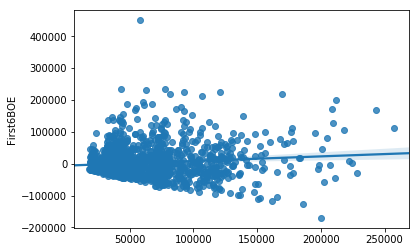

Predicting Texas
Training Scores: 0.2100 (+/- 0.0320)
Test Scores: 0.1327 (+/- 0.1974)



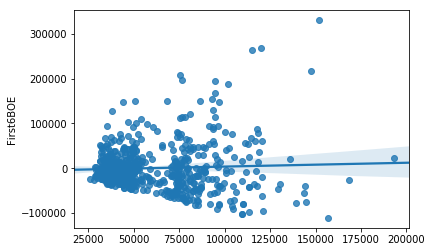

Predicting Montana
Training Scores: 0.2370 (+/- 0.0109)
Test Scores: 0.2193 (+/- 0.0589)



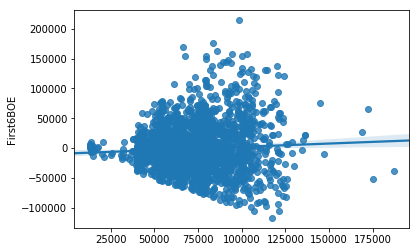

In [28]:
state_list = [['Oklahoma', okfeats, oktarget],
             ['Texas', txfeats, txtarget],
             ['Montana', mtfeats, mttarget]]

for states in state_list:
    print('Predicting {}'.format(states[0]))
    # Fit the model and generate training scores
    Xs_train, Xs_test, ys_train, ys_test = train_test_split(states[1], states[2], test_size=0.25, random_state=42)
    rfr_grid = RandomForestRegressor(**best_params, random_state=42)
    rfr_train = train_model(rfr_grid, Xs_train, ys_train, 5)
    # Generate test scores
    rfr_test = test_model(rfr_grid, Xs_test, ys_test, 5)

    print('Training Scores: {}'.format(rfr_train))
    print('Test Scores: {}'.format(rfr_test))
    print()
    y_pred = rfr_grid.predict(Xs_test)
    residuals = ys_test - y_pred
    sns.regplot(x=y_pred, y=residuals)
    plt.show()

From this analysis, these features are best able to predict the production in Oklahoma, with a R-squared score of 0.42 +/- 0.08.  These features were least able to predict Texas production, with the variance being larger than the R-squared value.

This could go back to data quality because the Oklahoma data had the frac information in the original data set, and did not have to be calculated and scraped from the fracfocus data.  Interestingly enough, the Texas data was also a part of that data set, yet it has dramatically lower R-squared scores.  This could be because Texas production differs in its methods or correlations to higher production.

## Conclusion
After performing this analysis on Colorado wells, I compared that analysis to that of Oklahoma, Texas, and Montana.  Using all four states combined, I was only able to explain the variance in 30% of the data.  This suggests that there are differences between well drilling, rock conditions, and probably production of different basins between the states.  The Colorado data was best able to explain the variance in Oklahoma, with an R-squared value of 0.3434 (+/- 0.21), however, when Colorado's data predicted that of Texas, the R-squared value decreased to 0.2361, but the variance also decreased to 0.070.  Colorado's well production was most different from Montana's, with an R-squared value of 0.0666 (+/- 0.12).   Looking at each state individually, Oklahoma was able to predict the greatest proportion of its variablity, with an R-squared score of 0.4147 (+/-0.080), followed by Montana and Texas, with R-squared values of 0.2193 (+/- 0.059), and 0.1327 (+/- 0.197), respectively.  Well operators can use this data to better understand how fracing works similarly between states, and this analysis could be transferred to further states, given appropriate data sources. 